# 2. (Grid)Survey

learn how create a geniric survey that observed anywhere in the sky

`Survey` and `GridSurvey` are object containing a footprint (imprint of the camera on the sky) and an observing strategy (where did you pointed the telescope with which filter etc.).

The main difference is that `GridSurvey` has a set of pre-defined **fields**, while `Survey` has not.

***
## Survey: *footprint* and *pointings*

let's start with the most generic survey. It needs:
- `data`: an observing strategy (ra, dec, mjd, band, zp, skynoise etc...)
- `footprint`: the camera footprint in the sky (in degree)

### 1. Define the footprint
for this example, let's use a simple 1 degree-radius camera footprint

The footprint in `skysurvey` is based on [shapely](https://shapely.readthedocs.io/en/stable/manual.html)

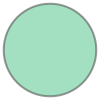

In [9]:
from shapely import geometry
footprint = geometry.Point(0,0).buffer(1)
footprint

### 2. Define the observing strategy

Say we will do 10_000 pointings: 
- `ra = [200,300]` and `dec =[-20,10]`. 
- `gain`: will be 1
- `skynoise`: between 150 ± 20
- `zp`: 30
- `mjd`: between march 2020 and april 2020
- `band`: will be desg, desr or desi

`skysurvey` data are based on `pandas.DataFrame` (you can provide dict, this will be converted though)

In [10]:
import pandas
import numpy as np
from skysurvey.tools import utils
from astropy.time import Time

In [11]:
from skysurvey.tools import utils
from astropy.time import Time
size = 10_000
data = {}

ra, dec = utils.random_radec(size=size, ra_range=[200,250], dec_range=[-20,10])
data["ra"] = ra
data["dec"] = dec
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=150, scale=20)
data["mjd"] = np.random.uniform(Time("2020-03-01").mjd, Time("2020-04-01").mjd, size=size)
data["band"] = np.random.choice(["desg","desr","desi"], size=size)

data = pandas.DataFrame.from_dict(data)
data.head()

,ra,dec,gain,zp,skynoise,mjd,band
0,223.143372,-6.944411,1,30,148.587835,58929.325842,desi
1,212.151246,7.226436,1,30,141.939662,58932.423623,desg
2,243.795803,-7.141388,1,30,156.022601,58926.818370,desr
3,244.861509,-0.881088,1,30,155.978842,58915.803057,desg
4,210.068846,-18.308755,1,30,159.737689,58932.207853,desi


### load a Survey  `from_pointings()`

In [12]:
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

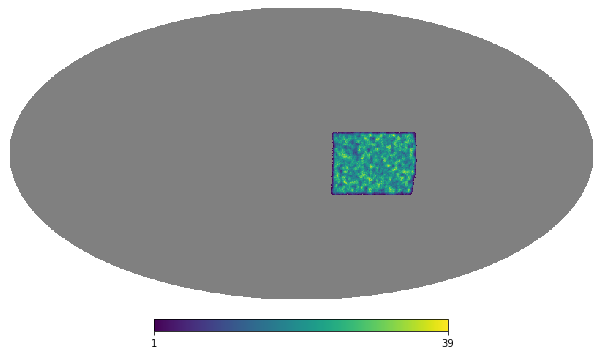

In [13]:
survey.show()

### DataFrame Based

survey.data (like any other skysurvey element) is a pandas.dataframe, so flexible and fast

In [16]:
survey.data # Show the data generated. time, band sky noise, gain, zp and fieldid.

,ra,dec,gain,zp,skynoise,mjd,band,fieldid_survey,fieldid
0,242.724442,9.977739,1,30,120.569679,58932.070312,desg,9324,194661
1,237.653259,9.975940,1,30,126.504181,58911.023438,desi,1802,194672
2,237.057388,9.980000,1,30,133.122223,58911.402344,desg,413,194673
3,235.550659,9.982522,1,30,165.378342,58909.343750,desi,6331,194677
4,231.759094,9.988463,1,30,150.361252,58930.246094,desi,8600,194685
...,...,...,...,...,...,...,...,...,...
365151,203.784210,-19.936001,1,30,149.026428,58923.703125,desr,9528,325947
365152,203.375153,-19.908487,1,30,139.055481,58919.449219,desi,8597,325948
365153,200.962845,-19.949831,1,30,198.391327,58910.242188,desi,2106,325953
365154,201.164810,-19.933077,1,30,156.069443,58929.726562,desi,7316,325953


### `Survey` is based on `healpix`

For `Survey` has no pre-defined fields, the sky is based on healpy. When you load the instance, `skysurvey` computes which healpix pixel has been observed. By default, healpix's **nside** is 200 (so a pixel is 0.08 deg^2 ; see `survey.get_field_area()`) ; **nside** is a Survey loading option.

In [17]:
# "field" surface in square degree. field here corresponds to a healpix pixel.
survey.get_field_area()

0.08594366926962348

### info: fieldids and fieldids_survey

- **fieldid**: unit of sky area, in Survey, that is healpix based, this corresponds to a healpix pixel.
- **fieldid_survey**: This is the fieldid corresponding to the initial pointing strategy you input (ra, dec).

Depending on you healpix resolution, you are likely to have many fieldid (healpix pixel) per fieldid_survey (footprint at the given RA, Dec). In that example, approximately 36. This makes sense since the camera has a "π deg^2" footprint, and the pixel area is 0.086 (pi/0.086 = 36.5)

In [18]:
survey.data.groupby("fieldid_survey")["fieldid"].nunique()

fieldid_survey
0       36
1       38
2       36
3       37
4       36
        ..
9995    38
9996    37
9997    35
9998    35
9999    37
Name: fieldid, Length: 10000, dtype: int64

In [19]:
survey.get_fieldstat("size") 

fieldid
194661    1
194672    1
194673    1
194677    1
194685    1
         ..
325945    1
325947    1
325948    1
325953    2
325954    1
Length: 18729, dtype: int64

### Matching coordinate with fields

This is an important feature that enable us to know whic field contains which target

In [20]:
survey.radec_to_fieldid([26, 70])

,fieldid
index_radec,
0,14425


In [21]:
import numpy as np
# remark that, doing that this way, it won't be homogeneous.
ra_flat = np.random.uniform(0, 190, 200)
dec_flat = np.random.uniform(-30, 90, 200)
survey.radec_to_fieldid([ra_flat,dec_flat])

,fieldid
index_radec,
0,287024
1,244382
2,12998
3,227733
4,193389
...,...
195,2573
196,280424
197,67468


***

## GridSurvey: *field*, *footprint* and *pointings*

Some surveys are observing **pre-defined fields**. That is the case for ZTF, that follows grid systems, or deep-fields surveys such as DES ou LSST.

A specific version of `Survey`, `GridSurvey` has been implemented for a more realistic user experience and to avoid **`healpix` pixel approximation** ; GridSurvey is also slight faster. To associate coordinates to fields `GridSurvey` is based on `shapely` and `geopandas` only (see skysurvey.survey.PolygonSurvey for details) ; no need for healpy

### Deep-Field Survey

let's use as an example two deep field surveys:

- "cosmos": 'ra':+150.11916667, 'dec':+2.20583333,
- "xmm-lss": 'ra':+35.7083333 ,'dec':-4.749999

and let's use a 8 degree size, square camera footprint

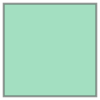

In [1]:
import numpy as np
from shapely import geometry
fields = {"cosmos": {'ra':+150.11916667, 'dec':+2.20583333},
          "xmm-lss": {'ra':+35.7083333 ,'dec':-4.749999}
         }

vertices_camera = np.asarray([[-0.5,-0.5],[0.5,-0.5], [0.5,0.5],[-0.5,0.5]]) * 8 
footprint = geometry.Polygon(vertices_camera)
footprint

### Define observation

Your observation should now not contain RA, Dec (this will be ignored), but a fieldid. 
Hence, using the very same example as above, but say we observed 10x more the cosmos field

In [23]:
import pandas
from skysurvey.tools import utils
from astropy.time import Time

size = 10_000
data = {}
# Data
data["fieldid"] = np.random.choice(["cosmos","xmm-lss"], 
                                   size=size, 
                                   p=np.asarray([10, 1])/11) # 10x 'cosmos' for 1x 'xmm-lss'
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(loc=150, scale=20,
                                    size=size)
data["mjd"] = np.random.uniform(Time("2020-03-01").mjd, Time("2020-04-01").mjd, 
                                size=size)
data["band"] = np.random.choice(["desg","desr","desi"], 
                                size=size)

data = pandas.DataFrame.from_dict(data)
data.head()

,fieldid,gain,zp,skynoise,mjd,band
0,cosmos,1,30,149.456081,58929.100134,desg
1,cosmos,1,30,132.602509,58919.958437,desr
2,cosmos,1,30,168.057022,58924.614704,desi
3,cosmos,1,30,154.332345,58929.651913,desi
4,cosmos,1,30,137.059974,58910.264817,desr


In [24]:
from skysurvey.survey import GridSurvey
gsurvey = GridSurvey.from_pointings(data, fields, footprint)

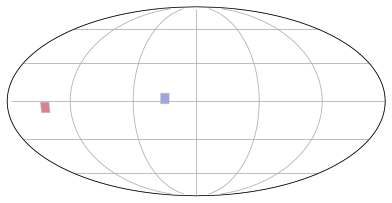

In [28]:
fig = gsurvey.show(vmin=0, vmax=10, cmap="coolwarm")

***
## Predefined Survey

- `ZTF` (GridSurvey)
- `DES` (GridSurvey) | deep-fields